<a href="https://colab.research.google.com/github/ZeyTrack/digit-recognizer/blob/main/Version2digit_reco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q gradio
!pip install shap

In [2]:
pip install --upgrade typing-extensions


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import shap
import gradio as gr

import tensorflow as tf
from tensorflow.keras.models import Sequential

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
original_data = pd.read_csv('/content/drive/MyDrive/lfd ass2/train.csv')
data = original_data.copy()
test = pd.read_csv('/content/drive/MyDrive/lfd ass2/test.csv')

In [6]:
data.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

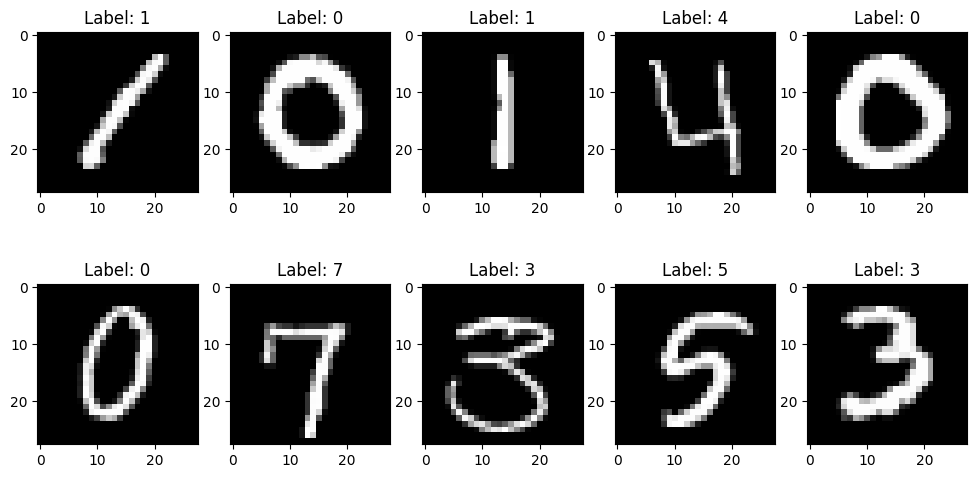

Class imbalance: 1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


In [7]:

# Visualize the first 10 digits
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(data.iloc[i, 1:].values.reshape(28, 28), cmap='gray')
    plt.title(f"Label: {data.iloc[i, 0]}")
plt.show()

# Check for class imbalance
class_count = data['label'].value_counts()
print(f"Class imbalance: {class_count}")


### 2. Check and clean the data from any missing values or duplications

*   List item
*   List item



In [8]:
# Check for missing values
print(f"Missing values in train set: {data.isnull().sum().sum()}")
print(f"Missing values in test set: {test.isnull().sum().sum()}")

# Check for duplicates
print(f"Number of duplicates in train set: {data.duplicated().sum()}")

Missing values in train set: 0
Missing values in test set: 0
Number of duplicates in train set: 0


In [9]:

dataX_train = data.drop('label', axis=1)
data_label_y_train = data['label']

### 3. Scale all the pixels values to be between 0 and 1 (values range from 0 to 255)

In [10]:
# Scale pixel values to be between 0 and 1
data.iloc[:, 1:] = data.iloc[:, 1:] / 255.0
test = test / 255.0

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


###4. Modelling and Training

1. Create your keras model with input, 1 or 2 hidden layers and an output layer with the number of classes in the target variable
2. Add 1 or more regularization in the netweork
3. Use relu activation function between the input and hidden layer and between the hidden and output layer
4. Use softmax activation function after the output layer to have probabilities for each class in the target variable
5. Use loss function that is suitable to multiclass classification problems
5. detemine the predicted class based on the max probability
6. Use Adam optimizer
7. Use early stopping
8. Use class weights to balance the classes in the target variable


In [11]:
#Create your keras model with input, 1 or 2 hidden layers and an output layer with the number of classes in the target variable
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2
tf.random.set_seed(1234)
# Define the number of classes in the target variable
num_classes = 10

# Define the model
model = Sequential()

# Add the input layer
model.add(Dense(512, activation='relu', input_shape=(784,)))

# Add the first hidden layer & Add 1 or more regularization in the netweork

model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))

# Add the second hidden layer (optional)
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))

# Add the output layer
model.add(Dense(num_classes, activation='softmax'))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 567434 (2.16 MB)
Trainable params: 567434 (2.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
#Use relu activation function between the input and hidden layer and between the hidden and output layer
from keras.models import Sequential
from keras.layers import Dense, Activation

# Define the model
model = Sequential()
model.add(Dense(64, input_dim=784, activation='relu'))
model.add(Dense(10, activation='relu'))

#Use softmax activation function after the output layer to have probabilities for each class in the target variable
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(10, input_shape=(784,)))
model.add(Activation('softmax'))

In [13]:
#Use loss function that is suitable to multiclass classification problems
from keras.losses import categorical_crossentropy
model.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy'])



In [14]:
#detemine the predicted class based on the max probability


# Predict the classes
predictions = model.predict(test)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes = [1 if p > 0.5 else 0 for p in predicted_classes]

875/875 [==============================] - 1s 1ms/step


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


# Create class weights to balance the classes
class_weights = compute_class_weight('balanced', classes=np.unique(data_label_y_train), y=data_label_y_train)
class_weight_dict = dict(enumerate(class_weights))

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(dataX_train, data_label_y_train, test_size=0.2, random_state=42)

# Create your keras model
model = Sequential()

# Add the input layer
model.add(Dense(512, activation='relu', input_shape=(784,)))

# Add the first hidden layer with L2 regularization
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))

# Add the second hidden layer (optional) with L2 regularization
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))

# Add the output layer with softmax activation
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',  # Use appropriate loss function
              optimizer=Adam(),  # Use Adam optimizer
              metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=20,  # Choose the number of epochs
                    batch_size=32,  # Choose the batch size
                    validation_data=(X_val, y_val),
                    class_weight=class_weight_dict,  # Use class weights
                    callbacks=[early_stopping])  # Use early stopping




Epoch 1/20
1050/1050 [==============================] - 6s 4ms/step - loss: 4.7685 - accuracy: 0.8836 - val_loss: 2.5720 - val_accuracy: 0.9306
Epoch 2/20
1050/1050 [==============================] - 5s 4ms/step - loss: 1.7523 - accuracy: 0.9508 - val_loss: 1.2344 - val_accuracy: 0.9429
Epoch 3/20
1050/1050 [==============================] - 4s 3ms/step - loss: 0.8087 - accuracy: 0.9640 - val_loss: 0.6321 - val_accuracy: 0.9473
Epoch 4/20
1050/1050 [==============================] - 4s 4ms/step - loss: 0.4167 - accuracy: 0.9657 - val_loss: 0.3451 - val_accuracy: 0.9586
Epoch 5/20
1050/1050 [==============================] - 5s 5ms/step - loss: 0.2559 - accuracy: 0.9673 - val_loss: 0.2546 - val_accuracy: 0.9594
Epoch 6/20
1050/1050 [==============================] - 4s 4ms/step - loss: 0.1872 - accuracy: 0.9715 - val_loss: 0.2566 - val_accuracy: 0.9486
Epoch 7/20
1050/1050 [==============================] - 4s 3ms/step - loss: 0.1579 - accuracy: 0.9723 - val_loss: 0.2034 - val_accuracy:

###6. Evaluation

1. Save the best model in google drive and load it after finishing the training
2. print a confusion matrix and classification report for the model predictions on the validation set
3. submit predictions on the test set on kaggle


In [16]:
from sklearn.metrics import confusion_matrix, classification_report




# Save the best model to Google Drive
model.save('/content/drive/MyDrive/lfd_ass2/best_model.h5')

# Load the saved model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/lfd_ass2/best_model.h5')

# Predictions on the validation set
val_predictions = loaded_model.predict(X_val)
val_predicted_classes = np.argmax(val_predictions, axis=1)

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_val, val_predicted_classes)
class_report = classification_report(y_val, val_predicted_classes)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


# Assuming 'test' is your test set for Kaggle
# Predictions on the test set
test_predictions = loaded_model.predict(test)
test_predicted_classes = np.argmax(test_predictions, axis=1)

# Prepare the submission file
submission_df = pd.DataFrame({'ImageId': range(1, len(test) + 1), 'Label': test_predicted_classes})

# Save the submission file
submission_df.to_csv('/content/drive/MyDrive/lfd_ass2/submission.csv', index=False)


You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


263/263 [==============================] - 1s 2ms/step
Confusion Matrix:
 [[796   0   7   0   0   1   9   1   0   2]
 [  0 903   5   0   0   0   0   0   1   0]
 [  1   6 831   1   4   0   0   2   0   1]
 [  1   1  14 908   0   2   1   4   2   4]
 [  2   5   5   0 802   0  10   0   0  15]
 [  0   1   0  17   0 664  11   1   4   4]
 [  2   2   4   0   0   4 769   0   4   0]
 [  0   1  14   1   3   0   0 865   0   9]
 [  1  10  11   7   3   2   5   2 788   6]
 [  0   3   1   8   7   1   0   3   1 814]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       816
           1       0.97      0.99      0.98       909
           2       0.93      0.98      0.96       846
           3       0.96      0.97      0.97       937
           4       0.98      0.96      0.97       839
           5       0.99      0.95      0.97       702
           6       0.96      0.98      0.97       785
           7       0.99      0.97    

###7. Deployment and Explainability

1. Use gardio to enable me uploading a gray scale 28 by 28 image and then output the predicted class
2. use shap values on the uploaded image and show it to me in the gardio app with the predicted class

In [19]:
import gradio as gr
import shap
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the SHAP explainer
explainer = shap.Explainer(loaded_model, X_train)

# Define the Gradio function for predictions and SHAP visualization
def predict_and_explain(image):
    # Convert the uploaded image to the format expected by the model
    img_array = cv2.cvtColor(image.astype('uint8'), cv2.COLOR_BGR2GRAY).reshape(1, 784) / 255.0

    # Predict the class
    prediction = loaded_model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Get SHAP values
    shap_values = explainer.shap_values(img_array)

    # Display the image
    plt.imshow(img_array.reshape(28, 28), cmap='gray')
    plt.title(f"Predicted Class: {predicted_class}")
    plt.show()

    # Display SHAP values
    shap.summary_plot(shap_values[0], img_array, feature_names=np.arange(784).astype(str))

    return f"Predicted Class: {predicted_class}"

# Create Gradio Interface
iface = gr.Interface(
    fn=predict_and_explain,
    inputs=gr.Image(type="numpy", image_mode="L"),
   # outputs="text"  # to get text
    outputs="image"  #to get image
)

# Launch Gradio Interface
iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://c02fc5560bf7f663aa.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
